In [ ]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 89 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
pd.set_option("display.max_columns", None)
warnings.simplefilter(action="ignore", category = Warning)

In [ ]:
df = pd.read_csv("diabetes.csv")
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

#Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=17)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Hiperparametre değişimi yapmadan önce ön tanımlı değerler ile alacağımız hataları da göz önünde bulunduralım:
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results["test_accuracy"].mean()

0.753896103896104

In [ ]:
cv_results["test_f1"].mean()

0.6190701534636385

In [ ]:
cv_results["test_roc_auc"].mean()

0.8233960113960114

#Hiperparametreler ön tanımlı hallerinde kullanıldığındaki hata sonuçları:
#ACCURACY = 0.753896103896104
#F1 = 0.6190701534636385
#ROC_AUC = 0.8233960113960114

#NOT: Hiperparametre optimizasyonu yapıldığı halde daha düşük sonuç almıyorsanız bunun sebebi:
* Ön tanımlı değerleri parametre setinizde bulundurmadığınızdan,
* Rastgelelikle ilgili olabilir.

In [ ]:
#Hiperparametre optimizasyonu yapalım:
#Ön tanımlı değerlerimizi de bu parametreye koyuyoruz çünkü çalışmanın en başında alınacak hatadan daha kötü bir hata elde etmemiş olalım.

rf_params = {"max_depth": [5, 8, None], #Derinlik
             "max_features": [3, 5, 7, "auto"], #Bölünmelerde göz önünde bulundurulması gereken değişken sayısı(Dikkat ! Veri setindeki değişken sayısından daha fazla olmamalı !!!)
             "min_samples_split": [2, 5, 8, 15, 20], #Bir düğümün dallanmaya maruz bırakılıp bırakılmayacağını karar vermek için kaç tane gözlem birimi olması gerektiği
             "n_estimators": [100, 200, 500]} #Random forest için birbirinden bağımsız fit edilecek (kurulacak olan) ağaç sayısı

#GridSearchCV kullanarak aramamızı yapalım:
#rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose =1).fit(X,y)

In [ ]:
def model_best_params(model, params, cv=5, n_jobs=-1, verbose =1, random_state =17):
  model_best_grid = GridSearchCV(model, params, cv=cv, n_jobs = n_jobs, verbose = verbose).fit(X,y)
  for x in model_best_grid.best_params_.keys():
    print('For {0} best param {1}'.format(x, model_best_grid.best_params_[x]))
  
  print("Set with the best parameters of your model...")
  final_model = model.set_params(**model_best_grid.best_params_, random_state = random_state).fit(X,y)
  return final_model

rf_final = model_best_params(rf_model, rf_params)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
For max_depth best param None
For max_features best param 5
For min_samples_split best param 8
For n_estimators best param 500
Set with the best parameters of your model...


In [ ]:
def cv_func(final_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"],returns=False):
  cv_results = cross_validate(final_model, X=X, y=y, cv=cv, scoring=scoring)
  for col in scoring:
    if col == "accuracy":
      print("Accuracy test mean = {0}".format(cv_results["test_accuracy"].mean()))
    elif col == "f1":
      print("F1 test mean = {0}".format(cv_results["test_f1"].mean()))
    elif col == "roc_auc":
      print("ROC_AUC test mean = {0}".format(cv_results["test_roc_auc"].mean()))
  if returns:
    return cv_results

cv_func(rf_final, X, y)

Accuracy test mean = 0.766848940533151
F1 test mean = 0.6447777811143756
ROC_AUC test mean = 0.8271054131054132


#Hiperparametre optimizasyonu yaparak aldığımız sonuçlar :
#ACCURACY = 0.766848940533151
#F1 = 0.6447777811143756
#ROC_AUC = 0.8271054131054132

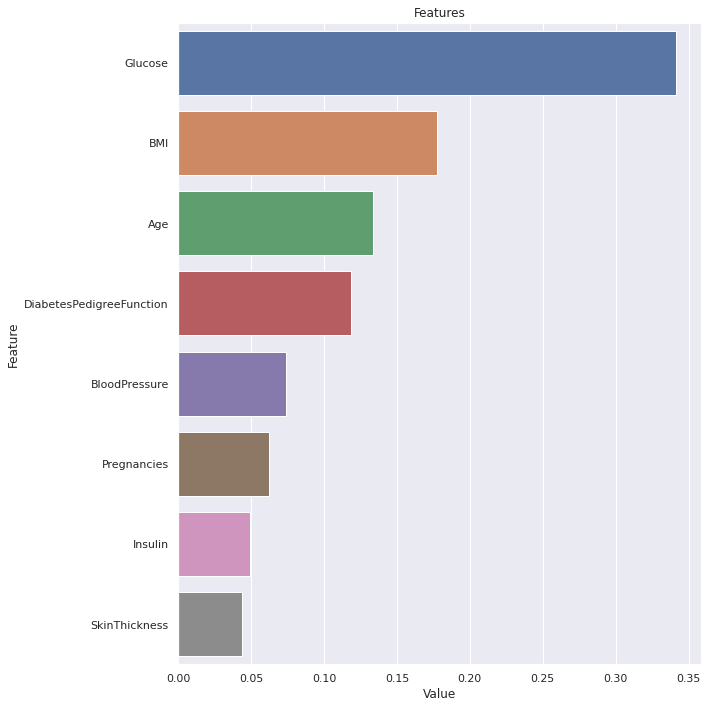

In [ ]:
def plot_importance(model,features,num=len(X),save=False):
  feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature":features.columns})
  plt.figure(figsize=(10,10))
  sns.set(font_scale=1)
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                   ascending=False)[0:num])
  plt.title("Features")
  plt.tight_layout()
  plt.show()
  if save:
    plt.savefig("importances.png")

plot_importance(rf_final, X)

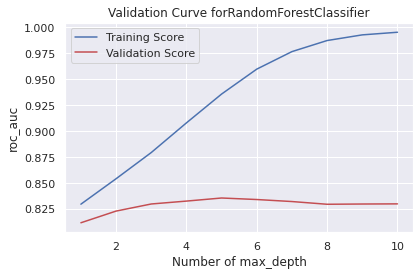

In [ ]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
  train_score, test_score = validation_curve(model, X = X, y = y,
                                           param_name = param_name,
                                           param_range = param_range,
                                           scoring=scoring,
                                           cv = cv)
  mean_train_score = np.mean(train_score, axis=1)
  mean_test_score = np.mean(test_score, axis=1)

  plt.plot(param_range, mean_train_score,
           label="Training Score", color="b")
  
  plt.plot(param_range, mean_test_score,
           label="Validation Score", color="r")
  
  plt.title(f"Validation Curve for{type(model).__name__}")
  plt.xlabel(f"Number of {param_name}")
  plt.ylabel(f"{scoring}")
  plt.tight_layout()
  plt.legend(loc="best")
  plt.show(block=True)

val_curve_params(rf_final, X, y, "max_depth", range(1,11))

In [ ]:
gbm_model = GradientBoostingClassifier(random_state = 17)
gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
def cv_func_result(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"],returns=False):
  cv_results = cross_validate(model, X=X, y=y, cv=cv, scoring=scoring)
  for col in scoring:
    if col == "accuracy":
      print("Accuracy test mean = {0}".format(cv_results["test_accuracy"].mean()))
    elif col == "f1":
      print("F1 test mean = {0}".format(cv_results["test_f1"].mean()))
    elif col == "roc_auc":
      print("ROC_AUC test mean = {0}".format(cv_results["test_roc_auc"].mean()))
  if returns:
    return cv_results

cv_func_result(gbm_model, X, y, cv=5)

Accuracy test mean = 0.7591715474068416
F1 test mean = 0.634235802826363
ROC_AUC test mean = 0.8254867225716283


In [ ]:
gbm_params = {"learning_rate":[0.01, 0.1],
              "max_depth":[3,8,10],
              "n_estimators":[100,500, 1000],
              "subsample":[1, 0.5, 0.7]}

def model_best_params(model, params, cv=5, n_jobs=-1, verbose =True, random_state =17):
  model_best_grid = GridSearchCV(model, params, cv=cv, n_jobs = n_jobs, verbose = verbose).fit(X,y)
  for x in model_best_grid.best_params_.keys():
    print('For {0} best param {1}'.format(x, model_best_grid.best_params_[x]))
  
  print("Set with the best parameters of your model...")
  model_final = model.set_params(**model_best_grid.best_params_, random_state = random_state).fit(X,y)
  return model_final

gbm_final = model_best_params(gbm_model, gbm_params)
gbm_final

Fitting 5 folds for each of 54 candidates, totalling 270 fits
For learning_rate best param 0.1
For max_depth best param 10
For n_estimators best param 100
For subsample best param 0.5
Set with the best parameters of your model...


GradientBoostingClassifier(max_depth=10, random_state=17, subsample=0.5)

In [ ]:
gbm_final = cv_func_result(gbm_final, X, y, cv=5)

Accuracy test mean = 0.7774127832951362
F1 test mean = 0.6624630868272237
ROC_AUC test mean = 0.8300300489168414
